In [146]:
import os
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn import metrics
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
# from dask_ml.feature_extraction.text import CountVectoriser

[nltk_data] Downloading package stopwords to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [147]:
# Load in the dictionary dataset into a pandas df
data_path = os.path.join(os.getcwd(), 'data', 'dictionary.txt')
dic = pd.read_csv(data_path, sep='|', header=None)

# ...and do the same with the sentiment_labels data
data_path = os.path.join(os.getcwd(), 'data', 'sentiment_labels.txt')
cents = pd.read_csv(data_path, sep='|')

dic = dic.rename(columns={0: "feature", 1: "ID"})# We rename the columns
# dic = dic.rename(index={range(239232)})
dic = dic.sort_values(by="ID") # We change the order of the rows to be sorted by ID number
movie_data = dic[["ID", "feature"]] # We change the order of the columns and change the name of the the df

# We make an array of the sentiments (already in the right order) and add it to our df
y = np.array(cents.iloc[:, -1])
movie_data.insert(2, "sentiment", y)

phrase_data = movie_data.sort_index()
phrase_data.drop("ID",axis=1,inplace=True)
phrase_data.insert(2,"label",0)

print(phrase_data.tail())

                                                  feature  sentiment  label
239227  zoning ordinances to protect your community fr...    0.13889      0
239228                                          zzzzzzzzz    0.19444      0
239229                                               élan    0.51389      0
239230                                                  É    0.50000      0
239231                   É um passatempo descompromissado    0.50000      0


In [148]:
small_N = 2390

rand = random.sample(range(239231), small_N)

rand_sample = phrase_data.iloc[rand]

rand_sample.head()

,feature,sentiment,label
15498,A much more successful translation,0.56944,0
18162,Amari 's film,0.50000,0
218178,to Massoud,0.50000,0
209588,"the pacing is deadly , the narration helps lit...",0.22222,0
109722,even original,0.55556,0


In [149]:
# phrases = phrase_data
phrases = rand_sample

In [150]:
### add correct labels based on sentiment column (uses qualities of numpy for efficiency)

# np_phrase = np.array(phrase_data)
np_phrase = np.array(phrases)

vpos = (0.8 < np_phrase[:, 1]).astype(int)
pos =  (0.6 < np_phrase[:, 1]).astype(int)
ntrl = (0.4 < np_phrase[:, 1]).astype(int)
neg = (0.2 < np_phrase[:, 1]).astype(int)
vneg = (0 <= np_phrase[:, 1]).astype(int)

h = vneg + neg + ntrl + pos + vpos - 1

np_phrase[:, 2] = h

# phrase_data = pd.DataFrame(np_phrase)
phrases = pd.DataFrame(np_phrase)
phrases.head()

,0,1,2
0,A much more successful translation,0.56944,2
1,Amari 's film,0.5,2
2,to Massoud,0.5,2
3,"the pacing is deadly , the narration helps lit...",0.22222,1
4,even original,0.55556,2


In [151]:
#data preprocessing
filler_words = set(stopwords.words('english'))

#values =[[0, 0.2], [0.2, 0.4], [0.4, 0.6], [0.6, 0.8], [0.8, 1.0]]
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
to_drop = []

for i in range(small_N):
    # 'clean' phrases: remove numbers, punctuation and filler words
    phrase = phrases.loc[i, 0]
    cleaned = re.sub(r'[^\w]', " ", phrase) #remove all special characters 
    cleaned = re.sub(r'[\d]', " ", cleaned)  #remove all numbers 
    if (cleaned.replace(" ","")==""):
        to_drop.append(i)
        cleaned=""
    else:
        cleaned = word_tokenize(cleaned.lower()) #tokenise for bag of words
        cleaned = [w for w in cleaned if w not in filler_words] # #remove all filler words
    phrases.loc[i, 0] = cleaned 

# remove unnecessary data
phrases.drop(1,axis=1,inplace=True) 
phrases.drop(to_drop,axis=0,inplace=True)
df = phrases[~phrases.astype(str).duplicated()]
df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)
print(df.head())
print(df.shape)

#save this as file
df.to_pickle("clean_rand_sample.pkl")
# df.to_pickle("clean_phrase_data.pkl")

                                            0  2
0             [much, successful, translation]  2
1                               [amari, film]  2
2                                   [massoud]  2
3  [pacing, deadly, narration, helps, little]  1
4                            [even, original]  2
(2351, 2)


C:\Users\Will Boyd\AppData\Local\Temp\ipykernel_27832\4149840140.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("index",axis=1,inplace=True)


In [152]:
# convert phrases to numerical representation: bag of words
phrases = pd.read_pickle("clean_rand_sample.pkl") 

#split phrase datasets to x and y
X_rand = phrases.loc[:, 0].copy()
y_rand = phrases.loc[:, 2].copy()

y_rand = y_rand.astype(int)

#create word vector 
vectorizer = CountVectorizer()
vectorizerfit = vectorizer.fit_transform(X_rand.astype(str))
names = vectorizer.get_feature_names_out()
count_array = vectorizerfit.toarray()
vec = pd.DataFrame(data=count_array,columns=names)

In [159]:
vec

,aaliyah,abbott,abc,abdul,ability,able,absent,absolutely,absorbed,abstract,...,youth,youthful,yu,yuppie,yvan,zany,zhang,zishe,zoe,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
# Feature importance

#split test and train
x_train, x_test, y_train, y_test = train_test_split(vec, y_rand, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(1645, 4725) (706, 4725) (1645,)


In [154]:
#naive bayes
clf = MultinomialNB()
clf.fit(x_train,y_train)
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.8674772036474164
0.4475920679886686


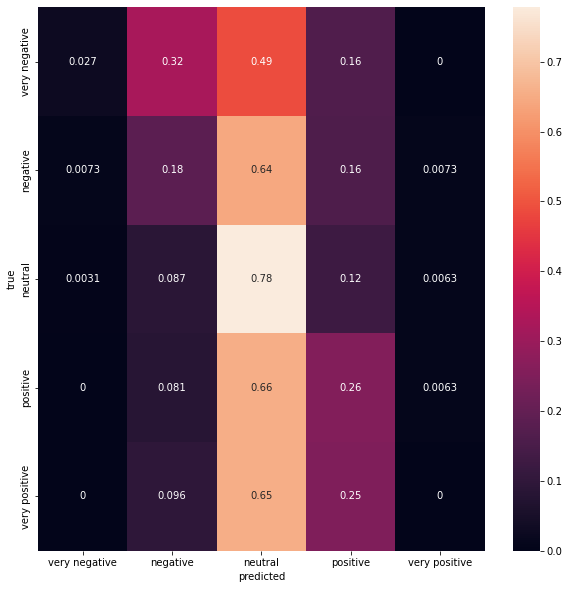

In [167]:
#above not great, maybe add in a regulariser?

#confusion matrix
matrix = confusion_matrix(y_test,clf.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("NB_confused.png")
plt.show()

In [156]:
#random forest - grid search for optimal decision tree parameters -maybe try dif criterion
rf_dic={
    "n_estimators":[10,50,200,500],
    "max_features": ["sqrt","log2"],
    "criterion": ["gini"],
    "max_depth": [4,8,30]
    }

rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator=rf,param_grid=rf_dic,cv=3)
grid_search.fit(x_train,y_train)

print("the best parameters are: " +str(grid_search.best_params_))

print("accuracy: " + str(grid_search.best_estimator_.score(x_test, y_test)*100) + "%")

the best parameters are: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
accuracy: 45.3257790368272%


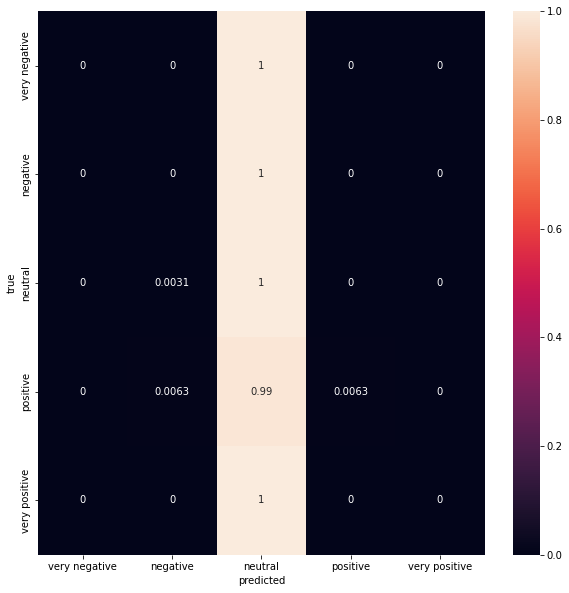

In [168]:
#confusion matrix
matrix = confusion_matrix(y_test,grid_search.best_estimator_.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("RandForest_confused.png")
plt.show()

In [171]:
#log reg

clf2 = LogisticRegression()
clf2.fit(x_train,y_train)
print(clf2.score(x_train,y_train))
print(clf2.score(x_test,y_test))

matrix2 = confusion_matrix(y_test,clf2.predict(x_test), normalize='true')


0.8996960486322189
0.46175637393767704


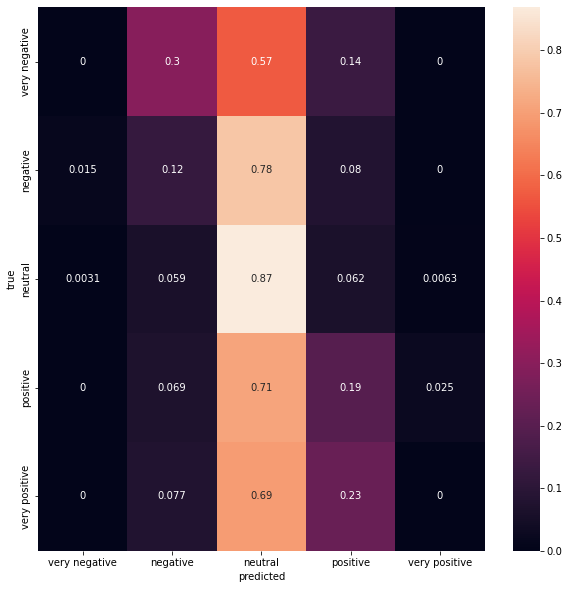

In [172]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix2, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("logreg_confused.png")
plt.show()